# Load *Library*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from google.colab import drive
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import MobileNetV2

# Data *Preparation*

In [ ]:
# Mount Google Drive
gdrive = "/content/drive/"
drive.mount(gdrive)

# Akses folder Dataset
dataset = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Dataset")
trainset = os.path.join(dataset, "train")
testset = os.path.join(dataset, "test")

Mounted at /content/drive/


# Data *Augmentation*

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = trainset,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 1920 images belonging to 30 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = trainset,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 480 images belonging to 30 classes.


# *Build Improve Model*

In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3),
                         alpha=1.0,
                         include_top=False,
                         weights="imagenet",
                         pooling="avg",
                         classes=30,
                         classifier_activation="softmax")

base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(30,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 30)                38430     
                                                                 
Total params: 2,301,534
Trainable params: 40,990
Non-tra

In [ ]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [ ]:
modelpath = os.path.join(gdrive, "Shareddrives/Capstone Bangkit/ML/Model/improve_model_with_MobileNetV2.h5")

checkpoint    = ModelCheckpoint(modelpath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 3.7228 - accuracy: 0.0865 
Epoch 1: val_accuracy improved from -inf to 0.12083, saving model to /content/drive/Shareddrives/Capstone Bangkit/ML/Model/improve_model_with_MobileNetV2.h5
30/30 [==============================] - 789s 26s/step - loss: 3.7228 - accuracy: 0.0865 - val_loss: 3.2782 - val_accuracy: 0.1208
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 2.7814 - accuracy: 0.2625
Epoch 2: val_accuracy improved from 0.12083 to 0.31458, saving model to /content/drive/Shareddrives/Capstone Bangkit/ML/Model/improve_model_with_MobileNetV2.h5
30/30 [==============================] - 59s 2s/step - loss: 2.7814 - accuracy: 0.2625 - val_loss: 2.8679 - val_accuracy: 0.3146
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 2.1825 - accuracy: 0.4203
Epoch 3: val_accuracy improved from 0.31458 to 0.38125, saving model to /content/drive/Shareddrives/Capstone Bangkit/ML/Model/improve_model_

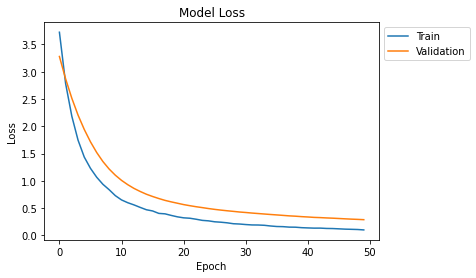

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

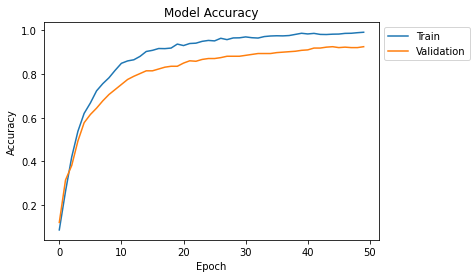

In [ ]:
# Summarize history for accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

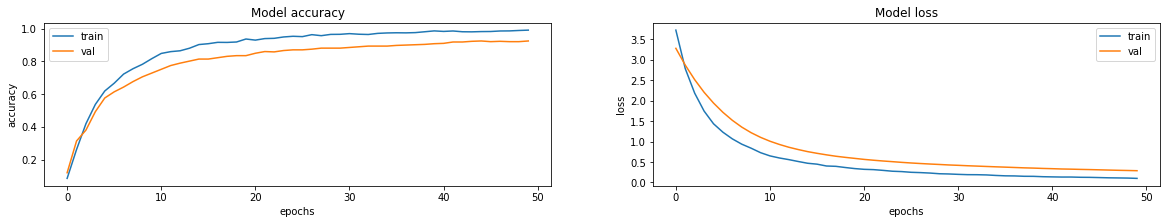

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# *Test The Improve Model*

In [ ]:
# Test Data 

lists_dir_datatest = os.listdir(testset)
categories_datatest = []
file_name_datatest = []
for folder in lists_dir_datatest:
  files = os.listdir(testset +"/"+folder)
  for file in files:
    path_file = testset + "/" + folder + "/" + file
    file_name_datatest.append(path_file)
    categories_datatest.append(folder)

df_datatest = {"image": file_name_datatest,"categories":categories_datatest}
data_datatest = pd.DataFrame(df_datatest, index = None)
data_datatest = data_datatest.sample(frac=1)
nb_samples=data_datatest.shape[0]
data_datatest

test_generator = test_datagen.flow_from_dataframe(dataframe=data_datatest,
                                                  dir=testset,
                                                  x_col='image',
                                                  y_col=None,
                                                  class_mode=None,
                                                  target_size=(224,224),
                                                  batch_size=64,
                                                  shuffle=False)

Found 600 validated image filenames.


In [ ]:
from keras.models import load_model
best_model = load_model(modelpath)

predict = best_model.predict(test_generator, batch_size=64)
pred = np.argmax(predict, axis=1)
pred

array([18, 24, 14, 23,  5, 24, 28, 28, 17, 10,  9,  4, 23, 13, 25, 22,  9,
        8, 19, 10, 29, 10, 26,  6, 11,  9, 26,  5, 21,  7,  9, 20, 20, 28,
       11, 27, 22, 16, 17, 11, 14,  9, 27, 17, 26, 10, 26,  0, 19, 27, 28,
        4,  3, 26, 27,  9, 11,  7, 26,  0, 24,  5, 12, 14, 17, 12, 15, 21,
       19, 12, 22,  9,  1,  2, 29,  3,  7,  0, 21, 16, 14, 28, 20, 12, 11,
        5, 15, 19, 15,  1, 27,  4, 24, 16, 14, 28, 11,  4,  6, 12,  1,  5,
       19, 17, 24, 14, 13,  1, 24,  8, 23,  5,  5, 24, 27, 19, 15, 27, 27,
       15, 21,  1, 28,  8,  6, 11, 26,  0, 29, 20, 18,  9, 12,  8, 12, 22,
        1, 25,  8,  3, 11, 20,  2, 20, 29,  4,  4, 11, 17, 15, 19, 23,  2,
       17, 13, 27, 25, 26, 21, 15, 23, 18, 10, 19, 21, 24, 14, 22, 16, 19,
       22, 19, 12, 15, 21, 21, 13,  6, 10, 27, 18, 20, 16,  7, 28,  0,  4,
       12,  6, 17, 24, 13,  7, 14, 26,  6,  7, 26, 26, 13,  6, 25,  0,  4,
       23,  9,  5, 20, 13, 10, 10, 24, 14, 10,  3,  0,  0, 22, 14,  3,  4,
       16,  9,  9, 28, 19

In [ ]:
true_classes=np.array(data_datatest['categories'].replace(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]))
true_classes

array([18, 24, 14, 23,  5, 24, 28, 28, 17, 10,  9,  4, 23, 13, 25, 22,  9,
        8, 19, 10, 29, 10, 26,  6, 11,  9, 26,  5, 21,  7,  9, 20, 20, 28,
       11, 27, 22, 16, 17, 11, 14,  9, 27, 20, 26, 10, 26,  0, 19, 27, 28,
        4,  3, 26, 27,  9, 11,  7, 26,  0, 24,  5, 12, 14, 17, 25, 15, 21,
       19, 12, 22,  9,  1,  2, 29,  3,  7,  0, 21, 16, 14, 28, 20, 12, 11,
        5, 15, 19, 15,  1, 27,  4, 24, 16, 14, 11, 12,  4,  6, 12,  1,  5,
       19, 17, 24, 14, 13,  1, 24,  8, 23,  5,  5, 24, 27, 19, 18, 27, 27,
       15, 21,  1, 28,  8,  6, 11, 26,  0, 29, 20, 18,  9, 12,  8, 12, 22,
        1, 25,  8,  3, 11, 20,  2, 17, 29,  4,  4, 11, 17, 15, 19, 23,  2,
       17, 13, 27, 25, 26, 21, 15, 23, 18, 10, 19, 21, 24, 14, 22, 16, 19,
       22, 19, 12, 15, 21, 21, 11,  6, 10, 27, 18, 20, 16,  7, 28,  0,  4,
       12,  6, 17, 24, 13,  7, 14, 26,  6,  7, 26, 26, 13,  6, 25,  0,  4,
       23,  9,  5, 17, 13, 10, 10, 24, 14, 10,  3,  0,  0, 22, 14,  3,  4,
       16,  9,  9, 28, 19

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(true_classes,pred)
cm

array([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

report=metrics.classification_report(true_classes, pred,target_names=class_labels)
report

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        20\n           1       1.00      1.00      1.00        20\n           2       1.00      1.00      1.00        20\n           3       1.00      1.00      1.00        20\n           4       1.00      1.00      1.00        20\n           5       1.00      1.00      1.00        20\n           6       1.00      1.00      1.00        20\n           7       1.00      1.00      1.00        20\n           8       1.00      1.00      1.00        20\n           9       1.00      1.00      1.00        20\n          ba       0.95      0.90      0.92        20\n          ca       0.89      0.85      0.87        20\n          da       0.85      0.85      0.85        20\n         dha       0.91      1.00      0.95        20\n          ga       0.95      1.00      0.98        20\n          ha       0.73      0.95      0.83        20\n          ja       1.00      1.00      1.00        20\n       

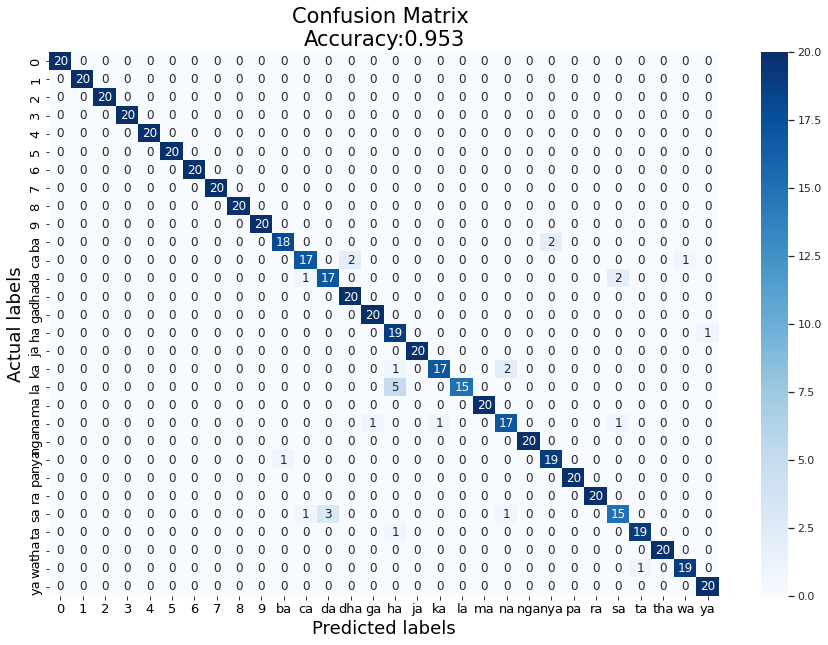

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 16})
sns.set(font_scale=1.0) #edited as suggested
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Actual labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix \nAccuracy:{0:.3f}'.format(accuracy_score(true_classes, pred)), fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=13)  # Adjust to fit
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']);
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']);